In [1]:
import sys
sys.path.append("./python")
import mpt
import numpy as np
import time
from tic_toc_timer import tic, toc


In [2]:
from python import simple_ml
import struct
import numpy as np
import gzip
def parse_mnist(image_filename, label_filename):
    def readLabels(filePath=label_filename):
        with gzip.open(filePath, 'rb') as f:
            return [struct.unpack('>II', f.read(8)), np.frombuffer(f.read(), dtype=np.uint8)]

    def readImages(filePath=image_filename):
        with gzip.open(filePath, 'rb') as f:
            [magic, images, rows, cols] = struct.unpack('>IIII', f.read(16))
            return np.resize(np.frombuffer(f.read(), dtype=np.uint8), (images, rows*cols))/np.float32(255)
    return (readImages(), readLabels()[1])
X_tr, y_tr = parse_mnist("data/train-images-idx3-ubyte.gz",
                             "data/train-labels-idx1-ubyte.gz")
X_te, y_te = parse_mnist("data/t10k-images-idx3-ubyte.gz",
                            "data/t10k-labels-idx1-ubyte.gz")
simple_ml.train_softmax(X_tr, y_tr, X_te, y_te, epochs=10, lr=0.1)

| Epoch | Train Loss | Train Err | Test Loss | Test Err |
|     0 |    0.38625 |   0.10812 |   0.36690 |  0.09960 |
|     1 |    0.34486 |   0.09748 |   0.32926 |  0.09180 |
|     2 |    0.32663 |   0.09187 |   0.31376 |  0.08770 |
|     3 |    0.31572 |   0.08867 |   0.30504 |  0.08510 |
|     4 |    0.30822 |   0.08667 |   0.29940 |  0.08320 |
|     5 |    0.30264 |   0.08508 |   0.29543 |  0.08250 |
|     6 |    0.29825 |   0.08393 |   0.29247 |  0.08180 |
|     7 |    0.29466 |   0.08305 |   0.29017 |  0.08120 |
|     8 |    0.29166 |   0.08215 |   0.28832 |  0.08070 |
|     9 |    0.28908 |   0.08137 |   0.28680 |  0.08080 |


In [2]:
# Load Data
data_dir="./data/"
batch_size=100
train_dataset = mpt.data.MNISTDataset(
    data_dir+"/train-images-idx3-ubyte.gz",
    data_dir+"/train-labels-idx1-ubyte.gz"
)
test_dataset = mpt.data.MNISTDataset(
    data_dir+"/t10k-images-idx3-ubyte.gz",
    data_dir+"/t10k-labels-idx1-ubyte.gz"
)
train_dataloader = mpt.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = mpt.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)


In [3]:
# Define network
import mpt.nn as nn

def simple_nn():
    return nn.Sequential(
        nn.Linear(784, 20),
        nn.Linear(20, 10)
    )
def loss_err(h, y):
    """ Helper function to compute both loss and error"""
    lossModule = nn.SoftmaxLoss()
    return (
        lossModule.forward(h, y),
        np.sum(h.numpy().argmax(axis=1) != y.numpy(), dtype=np.float32)
    )

In [12]:
#epoch
def epoch(dataloader: mpt.data.DataLoader,
          model: mpt.nn.Module,
          opt: mpt.optim.Optimizer = None):
    np.random.seed(4)

    if opt is None:
        model.eval()
    else :
        model.train()
    loss = 0
    err = 0
    i = 0
    num_sample = 0
    for _, data in enumerate(dataloader):
        imgs = data[0]
        labels = data[1]
        i += 1
        forwardRes = model.forward(imgs)
        iLoss, iError = loss_err(forwardRes, labels)
        loss += iLoss.numpy()[0]
        err += iError
        num_sample += labels.shape[0]
        if opt is not None:
            iLoss.backward()
            opt.step()

    print("{:.2f}% |   {:.5f}".format((err/num_sample)*100,loss/i))
    return (err/num_sample, loss/i)
    

In [13]:
# Train
train_acc, train_loss = None, None
model = simple_nn()
opt = mpt.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
print("Err | Loss")
for _ in range(10):
    train_acc, train_loss = epoch(train_dataloader, model=model, opt=opt)
test_acc, test_loss = epoch(test_dataloader, model=model)
print()
print("{:.5f} |   {:.5f}".format(test_acc, test_loss))

Err | Loss
12.44% |   0.44135
8.92% |   0.31548
8.45% |   0.29920
8.17% |   0.29102
8.00% |   0.28588
7.91% |   0.28228
7.82% |   0.27960
7.74% |   0.27752
7.69% |   0.27586
7.65% |   0.27450
7.94% |   0.27695

0.07940 |   0.27695


In [61]:
testImg=mpt.Tensor(test_dataset[0][0]).reshape((-1,1)).transpose()
testLabel=mpt.Tensor(test_dataset[0][1])
def loss_err(h, y):
    lossModule = nn.SoftmaxLoss()
    return (
        lossModule.forward(h, y),
        np.sum(h.numpy().argmax(axis=1) != y.numpy(), dtype=np.float32)
    )

In [75]:
h=model.forward(testImg)
y=testLabel
print(np.sum(h.numpy().argmax(axis=1) != y.numpy(), dtype=np.float32))

0.0


In [80]:
h2=net.forward(testImg)
y2=testLabel
print(h2)
print(h2.numpy().argmax(axis=1) != y2.numpy())
print(np.sum(h2.numpy().argmax(axis=1) != y2.numpy(), dtype=np.float32))

[[ 0.38178068 -0.45340216  0.46996555  0.6675435  -0.31004506  0.46440935
  -0.59473586  0.2853446  -1.3865604  -0.27761897]]
[ True]
1.0


# 展示例子 1 Matrix tiled Multiply

In [30]:
import sys
sys.path.append("./python")
import pandas as pd
import numpy as np
import mpt
import time
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        return time.time() - startTime_for_tictoc
    else:
        return None
sizes=[i for i in range(8,12*8,8)]

times = []
times2 = []

In [32]:
for sz in sizes:
    a=mpt.Tensor(np.random.randn(sz,sz),device=mpt.cpu())
    b=mpt.Tensor(np.random.randn(sz,sz),device=mpt.cpu())
    tic()
    for k in range(5):
        res=mpt.ops.matmul(a,b)
    costedTime=toc()
    times.append(costedTime)

    c=np.random.randn(sz,sz).astype('f')
    d=np.random.randn(sz,sz).astype('f')
    res2=np.ndarray((sz,sz))
    tic()
    for k in range(5):
        for i in range(sz):
            for j in range(sz):
                thissum=0
                for k in range(sz):
                    thissum+=c[i,j]*d[j,k]
                res2[i,k]=thissum
    times2.append(toc())

df = pd.DataFrame({'mpt.matmul': times, 'for loop': times2})
print(df.describe())

       mpt.matmul   for loop
count   11.000000  11.000000
mean     0.029474   0.991953
std      0.029106   1.072761
min      0.001546   0.007889
25%      0.005385   0.148626
50%      0.016561   0.642151
75%      0.050245   1.539648
max      0.078114   3.206719


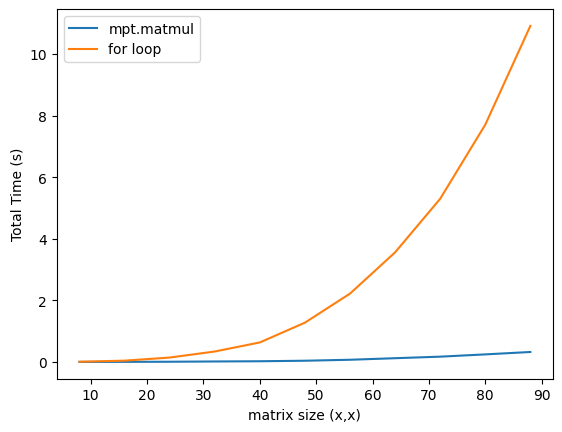

In [34]:
import matplotlib.pyplot as plt
# 计算时间记录到times和times2列表中

total_times = np.cumsum(times)
total_times2 = np.cumsum(times2)

plt.plot(sizes,total_times, label='mpt.matmul')
plt.plot(sizes,total_times2, label='for loop')
plt.xlabel('matrix size (x,x)')
plt.ylabel('Total Time (s)')
plt.legend()
plt.show()


# 展示例子2 自动求导

In [46]:
a=mpt.Tensor(4)
b=mpt.Tensor(2)
c=a+b
d=c*4
e=d/2
e.backward()

In [49]:
a.grad

mpt.Tensor(2.0)

# 展示例子3 模块化的神经网络

In [2]:
import sys
sys.path.append("./python")
import mpt
import mpt.nn as nn
lossModule = nn.SoftmaxLoss()
def simple_nn():
    return nn.Sequential(
        nn.Linear(2, 2),
        nn.Linear(2, 1)
    )

model=simple_nn()
model.forward(mpt.Tensor([[1,2]]))

mpt.Tensor([[1.7892647]])

In [5]:
print(model.modules[1].parameters())

[mpt.Tensor([[1.4103342]
 [0.9667679]]), mpt.Tensor([[-2.1842027]])]
